# Data Science Bowl 2018

Find cell nuclei in microscope images

https://www.kaggle.com/c/data-science-bowl-2018/data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [52]:
import os
import skimage.io
import numpy as np

import matplotlib.pyplot as plt

import data_loaders

# Load Data

In [35]:
datadir = "/home/christopher/Data/data/ml/data-science-bowl-2018/"

keys = os.listdir(datadir + "train")

data = {}

for key in keys:
    data[key] = skimage.io.imread(datadir + "train/" + key + "/images/" + key + ".png")
    data[key] = np.rollaxis(data[key], 2, 0) # make data channels, x, y

# Learn about our data

* Images are of many different sizes (256x256 - 1040x1388) but are all RGBA
* The majority of our images are grayscale - 562 / 670 in the training set
* All of the 'A' values are 255. We can throw those away.

## Decisions
* I think we should work exclusively in grayscale for now. We can try do clever things with color later but lets keep it simple
* We can't rely on having images of a certain size. We can either
    * Cut up images into consistent sizes
    * Resize - I don't like this at all. Especially as we need to (to the pixel level) locate things. This will introduce error there.

In [50]:
shapes = {}
for key in keys:
    shape = data[key].shape
    try:
        shapes[shape] += 1
    except KeyError:
        shapes[shape] = 1
print(shapes)

{(4, 360, 360): 91, (4, 520, 696): 92, (4, 256, 256): 334, (4, 256, 320): 112, (4, 1024, 1024): 16, (4, 260, 347): 5, (4, 512, 640): 13, (4, 603, 1272): 6, (4, 1040, 1388): 1}


In [48]:
is_grayscale = {True: 0, False: 0}
for key in keys:
    is_grayscale[np.all(data[key][0] == data[key][1]) and np.all(data[key][0] == data[key][2])] += 1
print(is_grayscale)

{True: 562, False: 108}


In [47]:

has_boring_a_values = {True: 0, False: 0}
for key in keys:
    has_boring_a_values[np.all(data[key][3] == 255)] += 1
print(has_boring_a_values)

{True: 670, False: 0}


# Masks

* We can find a distribution function of size of the masks
* Masks never overlap (I'm not sure what happens in the scoring function if we join objects).

In [61]:
masks = data_loaders.training_masks()

In [95]:
non_border_masks = data_loaders.filter_border_masks(masks)

In [97]:
print(len(masks[0]))
print(len(non_border_masks[0]))

20
10


3.05360375209


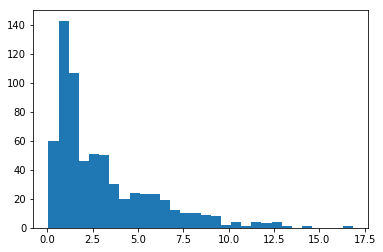

In [102]:
# Nuclei per area
nuclei_per_100_pixel = []
for nbm in non_border_masks:
    if len(nbm) == 0:
        continue  
    nuclei_per_100_pixel.append(10000 * len(nbm)/np.prod(nbm[0].shape))
print(np.mean(nuclei_per_100_pixel))
fig, ax = plt.subplots()
_ = ax.hist(nuclei_per_100_pixel, bins = 30)

# Size of nuclei
nb_nuclei_area = [np.count_nonzero(non_border_masks[i][j]) for i in range(len(non_border_masks)) for j in range(len(non_border_masks[i]))]
all_nuclei_area = [np.count_nonzero(masks[i][j]) for i in range(len(masks)) for j in range(len(masks[i]))]

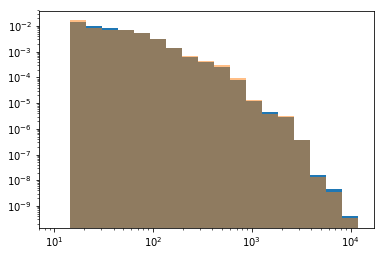

In [114]:
fig, ax = plt.subplots()
bins = np.logspace(1, np.log10(12000), num=20)
_ = ax.hist(all_nuclei_area, bins = bins, log=True, density=True, alpha=1)
_ = ax.hist(nb_nuclei_area, bins = bins, log=True, density=True, alpha=0.5)
_ = ax.set(
    xscale="log",
)

In [140]:
s_masks = data_loaders.single_masks(masks)

255


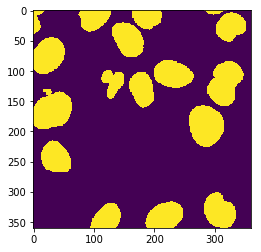

In [144]:
plt.imshow(s_masks[0])
print(max([np.max(i) for i in s_masks]))